In [129]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
from torchvision.io import read_image
from torchvision import transforms
from torchvision.transforms import ToTensor
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


In [130]:
train_annotation_file = 'task1/train_data/annotations.csv'
train_img_labeled_dir = 'images/labeled/'
train_img_unlabeled_dir = 'task1/train_data/images/unlabeled/'

val_img_dir = 'task1/val_data/'

In [131]:
df = pd.read_csv(train_annotation_file)

In [132]:
df.head()

,sample,label
0,task1/train_data/images/labeled/0.jpeg,0
1,task1/train_data/images/labeled/1.jpeg,1
2,task1/train_data/images/labeled/2.jpeg,2
3,task1/train_data/images/labeled/3.jpeg,3
4,task1/train_data/images/labeled/4.jpeg,4


In [133]:
print("Number of rows in the training dataset: ",df.shape[0])
print("Number of classes: ", df['label'].nunique())
print("Percentage of each class in the training dataset:\n\n",df['label'].value_counts()*100/df.shape[0])

Number of rows in the training dataset:  23555
Number of classes:  100
Percentage of each class in the training dataset:

 label
52    1.226916
5     1.226916
3     1.214180
8     1.188707
82    1.188707
        ...   
83    0.721715
75    0.708979
92    0.662280
89    0.632562
96    0.318404
Name: count, Length: 100, dtype: float64


In [134]:
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [135]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15), 
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    
])

In [136]:
class AAITDataset(Dataset):
    def __init__(self, dataset, img_dir, is_train=True, transform=None, target_transform=None):
        self.is_train = is_train
        if self.is_train:
            self.img_labels = dataset
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        if self.is_train:
            return len(self.img_labels)
        else:
            self.img_files = [f for f in os.listdir(self.img_dir) if os.path.isfile(os.path.join(self.img_dir, f))]
            return len(self.img_files)

    def __getitem__(self, idx):
        if self.is_train:
            img_path = self.img_labels.iloc[idx, 0]
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            #print(image)
            if image.size()[0] == 1:
                image = image.expand(3, -1, -1)
            label = self.img_labels.iloc[idx, 1]
            
            if self.target_transform:
                label = self.target_transform(label)
            return image, label, img_path
        else: 
            img_path = os.path.join(self.img_dir, self.img_files[idx])
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            if image.size(0) == 1:
                image = image.expand(3, -1, -1)
            
            return image, img_path

In [137]:
train_dataset = AAITDataset(train_data, train_img_labeled_dir, is_train=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = AAITDataset(test_data, train_img_labeled_dir, is_train=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

train_unlabeled_dataset = AAITDataset(None, train_img_unlabeled_dir, is_train=False, transform=transform)
train_unlabeled_dataloader = DataLoader(train_unlabeled_dataset, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 64, 64])
Labels batch shape: torch.Size([64])


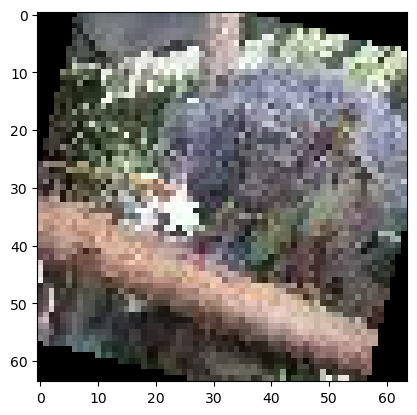

Label: 16


In [138]:
train_features, train_labels, _ = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([64, 3, 64, 64])


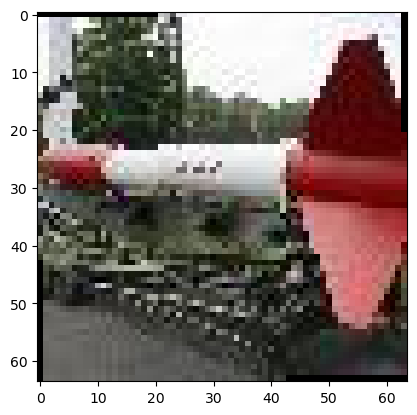

In [139]:
train_features, _ = next(iter(train_unlabeled_dataloader))
print(f"Feature batch shape: {train_features.size()}")
img = train_features[0].squeeze()
plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.show()

In [140]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    print(mps_device)
else:
    print("MPS not found!")

mps


In [141]:
%%time
from torchvision import models

class CustomModel(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(CustomModel, self).__init__()
        
        self.resnet50 = models.resnet50(weights="IMAGENET1K_V2") # pretrained = True

        num_features = self.resnet50.fc.in_features
        self.dropout = nn.Dropout(p=0.1)
        self.resnet50.fc = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            self.dropout,
            nn.Linear(1024, num_classes)
        )
        #self.resnet50.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        
        return self.resnet50(x)


teacher_model = CustomModel(num_classes=100, pretrained=True).to(mps_device)
student_model = CustomModel(num_classes=100, pretrained=True).to(mps_device)

def train_model(model, train_dataloader, criterion, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for images, labels, _ in tqdm(train_dataloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = total_loss / len(train_dataloader)
        epoch_acc = 100 * correct / total
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels, _ in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, accuracy, precision, recall, f1

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(teacher_model.parameters(), lr=0.00001)
optimizer = torch.optim.SGD(teacher_model.parameters(), lr=0.001, momentum=0.9)
train_model(teacher_model, train_dataloader, criterion, optimizer, epochs=30, device=mps_device)
avg_loss, acc, prec, rec, f1 = evaluate_model(teacher_model, test_dataloader, criterion, mps_device)
print("Results:")
print("Average loss: ", avg_loss)
print("Accuracy: ", acc*100)
print("Precision: ", prec*100)
print("Recall: ", rec*100)
print("F1 score: ", f1*100)

100%|██████████| 295/295 [00:38<00:00,  7.72it/s]


Epoch 1/30, Loss: 4.4373, Accuracy: 10.74%


100%|██████████| 295/295 [00:54<00:00,  5.46it/s]


Epoch 2/30, Loss: 3.1062, Accuracy: 39.16%


100%|██████████| 295/295 [00:59<00:00,  4.98it/s]


Epoch 3/30, Loss: 1.8755, Accuracy: 54.96%


100%|██████████| 295/295 [00:59<00:00,  4.95it/s]


Epoch 4/30, Loss: 1.4514, Accuracy: 62.76%


100%|██████████| 295/295 [00:59<00:00,  4.97it/s]


Epoch 5/30, Loss: 1.2339, Accuracy: 67.70%


100%|██████████| 295/295 [00:58<00:00,  5.00it/s]


Epoch 6/30, Loss: 1.0926, Accuracy: 70.81%


100%|██████████| 295/295 [00:58<00:00,  5.04it/s]


Epoch 7/30, Loss: 0.9736, Accuracy: 73.99%


100%|██████████| 295/295 [00:57<00:00,  5.10it/s]


Epoch 8/30, Loss: 0.8692, Accuracy: 76.58%


100%|██████████| 295/295 [00:57<00:00,  5.17it/s]


Epoch 9/30, Loss: 0.7807, Accuracy: 78.50%


100%|██████████| 295/295 [00:56<00:00,  5.19it/s]


Epoch 10/30, Loss: 0.7007, Accuracy: 80.49%


100%|██████████| 295/295 [00:58<00:00,  5.03it/s]


Epoch 11/30, Loss: 0.6422, Accuracy: 81.83%


100%|██████████| 295/295 [00:57<00:00,  5.10it/s]


Epoch 12/30, Loss: 0.5776, Accuracy: 84.14%


100%|██████████| 295/295 [00:58<00:00,  5.03it/s]


Epoch 13/30, Loss: 0.5245, Accuracy: 85.35%


100%|██████████| 295/295 [00:59<00:00,  5.00it/s]


Epoch 14/30, Loss: 0.4641, Accuracy: 87.11%


100%|██████████| 295/295 [01:00<00:00,  4.91it/s]


Epoch 15/30, Loss: 0.4333, Accuracy: 87.84%


100%|██████████| 295/295 [00:58<00:00,  5.06it/s]


Epoch 16/30, Loss: 0.3884, Accuracy: 89.30%


100%|██████████| 295/295 [00:56<00:00,  5.25it/s]


Epoch 17/30, Loss: 0.3538, Accuracy: 90.16%


100%|██████████| 295/295 [00:54<00:00,  5.37it/s]


Epoch 18/30, Loss: 0.3181, Accuracy: 91.01%


100%|██████████| 295/295 [00:55<00:00,  5.28it/s]


Epoch 19/30, Loss: 0.2826, Accuracy: 92.15%


100%|██████████| 295/295 [00:56<00:00,  5.25it/s]


Epoch 20/30, Loss: 0.2575, Accuracy: 92.69%


100%|██████████| 295/295 [00:56<00:00,  5.21it/s]


Epoch 21/30, Loss: 0.2450, Accuracy: 93.08%


100%|██████████| 295/295 [00:56<00:00,  5.20it/s]


Epoch 22/30, Loss: 0.2191, Accuracy: 93.88%


100%|██████████| 295/295 [00:56<00:00,  5.25it/s]


Epoch 23/30, Loss: 0.1988, Accuracy: 94.33%


100%|██████████| 295/295 [00:56<00:00,  5.24it/s]


Epoch 24/30, Loss: 0.1716, Accuracy: 95.36%


100%|██████████| 295/295 [00:56<00:00,  5.22it/s]


Epoch 25/30, Loss: 0.1630, Accuracy: 95.46%


100%|██████████| 295/295 [00:56<00:00,  5.23it/s]


Epoch 26/30, Loss: 0.1548, Accuracy: 95.79%


100%|██████████| 295/295 [00:56<00:00,  5.24it/s]


Epoch 27/30, Loss: 0.1362, Accuracy: 96.35%


100%|██████████| 295/295 [00:40<00:00,  7.34it/s]


Epoch 28/30, Loss: 0.1308, Accuracy: 96.53%


100%|██████████| 295/295 [00:36<00:00,  8.12it/s]


Epoch 29/30, Loss: 0.1147, Accuracy: 96.83%


100%|██████████| 295/295 [00:36<00:00,  8.10it/s]


Epoch 30/30, Loss: 0.1037, Accuracy: 97.22%
Results:
Average loss:  1.3081598644321029
Accuracy:  71.364890681384
Precision:  72.0496330249744
Recall:  71.364890681384
F1 score:  71.3694082832044
CPU times: user 11min 58s, sys: 1min 31s, total: 13min 29s
Wall time: 27min 28s


In [142]:
def generate_pseudo_labels(model, dataloader):
    model.eval()
    pseudo_label_data = []
    with torch.no_grad():
        for images, img_paths in dataloader:
            images = images.to(mps_device)
            outputs = model(images)
            probs, predicted = torch.max(outputs, 1)
            
            
            for img_path, label in zip(img_paths, predicted):
                pseudo_label_data.append((img_path, label.item()))

    pseudo_labels_df = pd.DataFrame(pseudo_label_data, columns=['sample', 'label'])
    return pseudo_labels_df


pseudo_labels = generate_pseudo_labels(teacher_model, train_unlabeled_dataloader)


In [143]:
pseudo_labels.to_csv('task1/train_data/annotations_pseudo.csv', index=False)

In [144]:
from torch.utils.data import ConcatDataset

train_dataset = AAITDataset(df, train_img_labeled_dir, is_train=True, transform=transform)
#train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

train_annotation_file_un = 'task1/train_data/annotations_pseudo.csv'
train_img_unlabeled_dir = 'images/unlabeled/'

train_dataset_un = AAITDataset(pseudo_labels, train_img_unlabeled_dir, is_train=True, transform=transform)
#train_dataloader_un = DataLoader(train_dataset_un, batch_size=64, shuffle=True)

combined_dataset = ConcatDataset([train_dataset, train_dataset_un])
combined_dataloader = DataLoader(combined_dataset, batch_size=64, shuffle=True)


In [145]:
#optimizer = torch.optim.Adam(student_model.parameters(), lr=0.00001)
optimizer = torch.optim.SGD(student_model.parameters(), lr=0.001, momentum=0.9)
train_model(student_model, combined_dataloader, criterion, optimizer, epochs=20, device=mps_device)


100%|██████████| 782/782 [01:44<00:00,  7.49it/s]


Epoch 1/20, Loss: 3.4277, Accuracy: 29.67%


100%|██████████| 782/782 [01:45<00:00,  7.41it/s]


Epoch 2/20, Loss: 1.4536, Accuracy: 62.24%


100%|██████████| 782/782 [01:43<00:00,  7.55it/s]


Epoch 3/20, Loss: 1.1159, Accuracy: 69.81%


100%|██████████| 782/782 [01:41<00:00,  7.72it/s]


Epoch 4/20, Loss: 0.9571, Accuracy: 73.57%


100%|██████████| 782/782 [01:58<00:00,  6.62it/s]


Epoch 5/20, Loss: 0.8301, Accuracy: 76.84%


100%|██████████| 782/782 [01:23<00:00,  9.40it/s]


Epoch 6/20, Loss: 0.7370, Accuracy: 79.01%


100%|██████████| 782/782 [01:21<00:00,  9.64it/s]


Epoch 7/20, Loss: 0.6521, Accuracy: 81.32%


100%|██████████| 782/782 [01:21<00:00,  9.55it/s]


Epoch 8/20, Loss: 0.5719, Accuracy: 83.46%


100%|██████████| 782/782 [01:21<00:00,  9.54it/s]


Epoch 9/20, Loss: 0.5165, Accuracy: 84.86%


100%|██████████| 782/782 [01:21<00:00,  9.57it/s]


Epoch 10/20, Loss: 0.4546, Accuracy: 86.69%


100%|██████████| 782/782 [01:21<00:00,  9.63it/s]


Epoch 11/20, Loss: 0.4045, Accuracy: 88.05%


100%|██████████| 782/782 [01:02<00:00, 12.61it/s]


Epoch 12/20, Loss: 0.3616, Accuracy: 89.29%


100%|██████████| 782/782 [00:58<00:00, 13.30it/s]


Epoch 13/20, Loss: 0.3250, Accuracy: 90.35%


100%|██████████| 782/782 [00:59<00:00, 13.18it/s]


Epoch 14/20, Loss: 0.2875, Accuracy: 91.47%


100%|██████████| 782/782 [00:58<00:00, 13.41it/s]


Epoch 15/20, Loss: 0.2532, Accuracy: 92.41%


100%|██████████| 782/782 [01:15<00:00, 10.39it/s]


Epoch 16/20, Loss: 0.2284, Accuracy: 93.27%


100%|██████████| 782/782 [01:21<00:00,  9.61it/s]


Epoch 17/20, Loss: 0.2066, Accuracy: 93.89%


100%|██████████| 782/782 [01:21<00:00,  9.58it/s]


Epoch 18/20, Loss: 0.1868, Accuracy: 94.42%


100%|██████████| 782/782 [01:21<00:00,  9.61it/s]


Epoch 19/20, Loss: 0.1661, Accuracy: 95.05%


100%|██████████| 782/782 [01:19<00:00,  9.79it/s]

Epoch 20/20, Loss: 0.1539, Accuracy: 95.46%


In [146]:
val_unlabeled_dataset = AAITDataset(None, val_img_dir, is_train=False, transform=transform2)
val_unlabeled_dataloader = DataLoader(val_unlabeled_dataset, batch_size=64, shuffle=False)

val_labels = generate_pseudo_labels(student_model, val_unlabeled_dataloader)
val_labels['sample'] = val_labels['sample'].apply(lambda x: x.split('/')[-1])


In [147]:
val_labels['sort_key'] = val_labels['sample'].str.extract('(\d+)').astype(int)
val_labels.sort_values(by='sort_key', ascending=True, inplace=True)
val_labels.reset_index(inplace=True)
val_labels.drop(columns=['sort_key','index'], inplace=True)

val_labels.to_csv('task1/simple_pseudo_labels.csv', index=False)